In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Zad.1

In [2]:
def random_population(chromosome_length, mi, x_bounds, s_bounds):
    res=np.full((mi, 2, chromosome_length), 0.0)
    for num_of_child in range(mi):
        res[num_of_child, 0, :]=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], chromosome_length)
    return res

In [3]:
def parent_selection(P, evaluation_result, lambda_param):
    indices=np.random.choice(len(evaluation_result), lambda_param)
    return P[indices]

In [4]:
def mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
    return P_children

In [5]:
def replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=True, looking_for_max=False):
    if not is_mi_plus_lambda:
        indices=np.argsort(-children_evaluation_result)[:mi_param] if looking_for_max else np.argsort(children_evaluation_result)[:mi_param]
        return  P_children[indices], children_evaluation_result[indices]
    else:
        all_evaluation_results=np.concatenate((evaluation_result, children_evaluation_result))
        full_population=np.concatenate((P, P_children))
        indices=np.argsort(-all_evaluation_results)[:mi_param] if looking_for_max else np.argsort(all_evaluation_results)[:mi_param]
        return full_population[indices], all_evaluation_results[indices]

In [6]:
def eval_population(objective_function, population):
    population_size=len(population)
    results=np.zeros(population_size)
    for i in range(population_size):
        results[i] = objective_function(population[i])
    return results

In [13]:
def ES_mi_lambda(objective_function, chromosome_length, mi_param, lambda_param, x_bounds, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=False):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=random_population(chromosome_length, mi_param, x_bounds, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, 
                                          is_mi_plus_lambda=is_mi_plus_lambda, looking_for_max=looking_for_max)
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

In [14]:
def plot_chart(P):
    plt.figure(figsize=(20, 7))
    plt.plot(P[1], label="Max results")
    plt.plot(P[2], label="Mean results")
    plt.plot(P[3], label="Min results")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()

## Benchmarks:

Sphere

In [15]:
def sphere(individual):
    return np.sum(individual * individual)
print(sphere(np.array([1.0, 2.0, 3.0])))

14.0


Mi + lambda

20


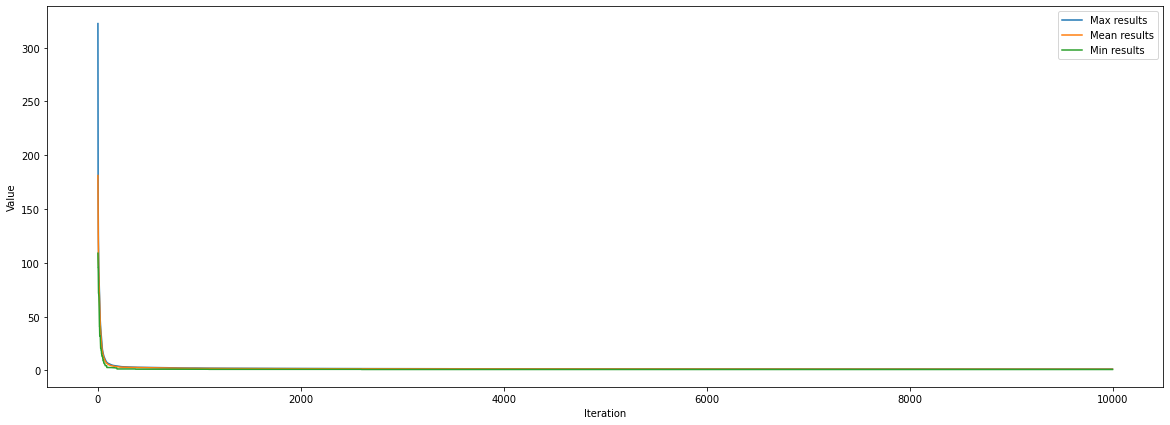

[ 0.22946352  0.25777332 -0.09813916 -0.1247777   0.00545345 -0.17410331
 -0.01618396  0.39992109  0.39725027  0.1221803   0.04929279 -0.04609402
 -0.01564896  0.13866326  0.02008813 -0.10656055 -0.42460354 -0.06948237
 -0.14239094 -0.24911315]
50


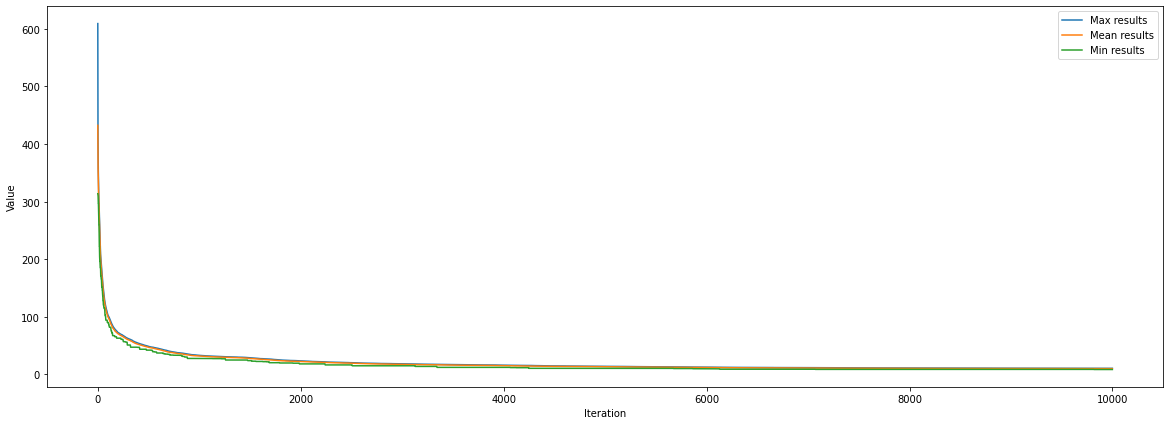

[ 0.01065654  0.22907166  0.38210293 -0.40485248 -0.13717006  0.59297871
  0.45223488  0.33276469  0.94312865 -0.30006684 -0.47400187 -0.22969408
 -0.37022164  0.23754928 -0.55740314 -0.41087122  0.37526419 -0.2449475
 -0.10825466  0.01051213 -0.19476966  0.15585728 -0.86780317  0.14095937
  0.24702873  0.08882721 -0.45499516 -0.05812081 -0.56694229 -0.39675687
  0.47014633 -0.32246295 -0.05692081 -0.86657982  0.08424294 -0.39993662
 -0.3622446   0.3099639   0.29722208 -0.59137092 -0.24948785  0.45617673
 -0.3734758   0.41363252 -0.27280392  0.19698291  0.37255037 -0.58089682
 -0.19321848 -0.65324549]
100


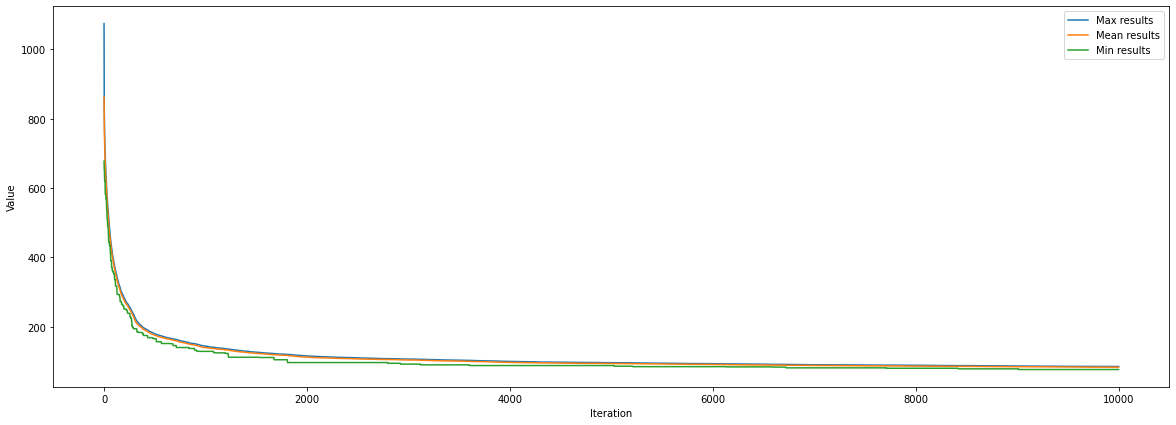

[-0.10776795  0.13085613  1.31055716 -1.44377798 -2.65218641 -2.01256877
  0.62385311  0.6380984   0.13258038 -0.10016614  0.30330935 -1.00627641
 -0.70717877 -0.80439724 -0.45119373 -0.42176092  1.28281078 -0.9487831
 -0.09032844  0.34244053  1.11979112 -0.36209028  0.28782667  0.52119509
 -0.893661   -0.38401289  1.77843304 -0.3126978  -0.16444258 -1.78253373
 -0.19119716  0.33155416  0.21908829  0.39799702 -0.97847616 -1.27049194
  0.25761131  1.91483817  0.85603092 -1.09558774  0.64121096  0.34619086
 -0.57269823 -0.34369485  0.65135448 -0.12918318 -0.15230934 -0.0271047
  0.11894954  0.95989993 -0.42725353  0.24362623 -0.12886476 -0.90598705
  0.01895964  0.63297202 -0.40669685  0.03360105 -0.34645485 -0.52045181
  1.41028955 -0.35276421  0.15645826 -1.3832051  -0.4419489  -0.57428473
  0.67697927 -0.30149561  0.73893308 -0.62337599  1.03765463  0.69982181
 -0.99594914 -0.79168254 -0.01129459  0.17709737  0.92866564  0.30091533
 -1.64595033 -0.32627014  0.07884186  0.50618722  1.4

In [17]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(sphere, chromosomes, 100, 100, (-5.12, 5.12))
    plot_chart(res)
    print(res[0])

Mi, lambda

20


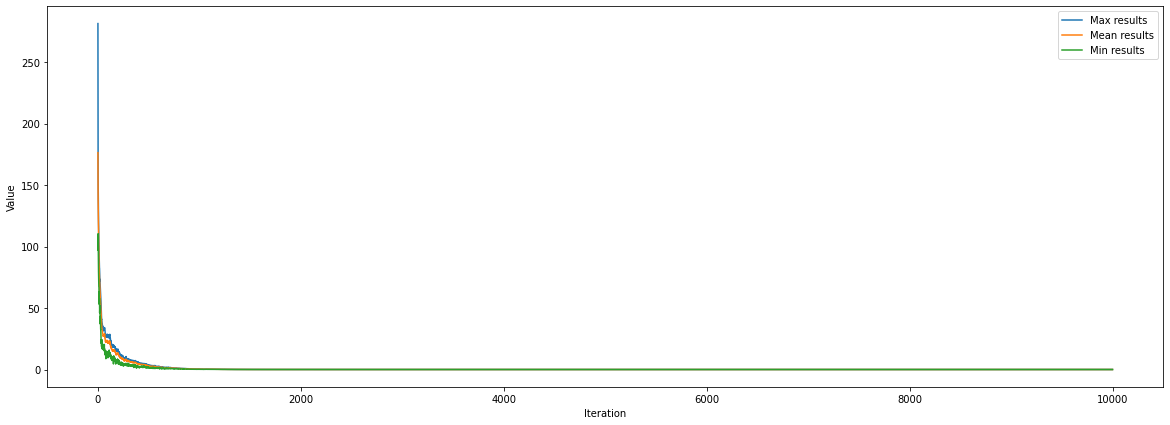

[ 7.78675156e-10  6.51012186e-10  1.73446904e-10  6.86408368e-10
  6.78165406e-10 -6.28670762e-10  2.13572065e-10  2.68548968e-10
  4.86614290e-10  5.08001099e-10  9.05796058e-10  2.78038184e-11
  2.77132489e-10 -2.92555917e-10 -1.11107261e-10 -1.47117303e-11
  1.59287336e-09  9.09017817e-10 -3.00484328e-10 -1.83144874e-10]
50


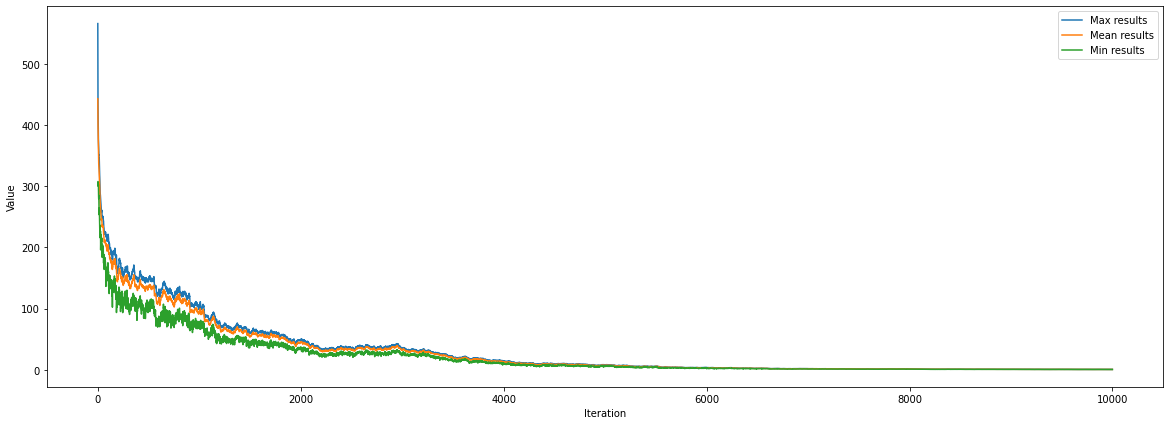

[-0.03686456 -0.00976995 -0.15956431 -0.01290186  0.0069733  -0.068492
  0.07583138  0.0596889  -0.03322    -0.00991891  0.01127932 -0.14356309
  0.09875487 -0.04297747  0.05564952  0.08398984 -0.09173657  0.02874005
 -0.0763086   0.06693567  0.0101939   0.00938605 -0.01866558  0.0021346
  0.07694914  0.04925365 -0.14777003 -0.00148748 -0.02757113  0.06668701
 -0.02545205  0.0365251   0.03768076  0.04641978  0.06380844 -0.08419925
  0.02241305 -0.0375516  -0.14552875 -0.01308004 -0.01288511 -0.12196351
  0.06334964  0.064476    0.09919246  0.02000152 -0.06201459  0.00198746
  0.01505436 -0.00224351]
100


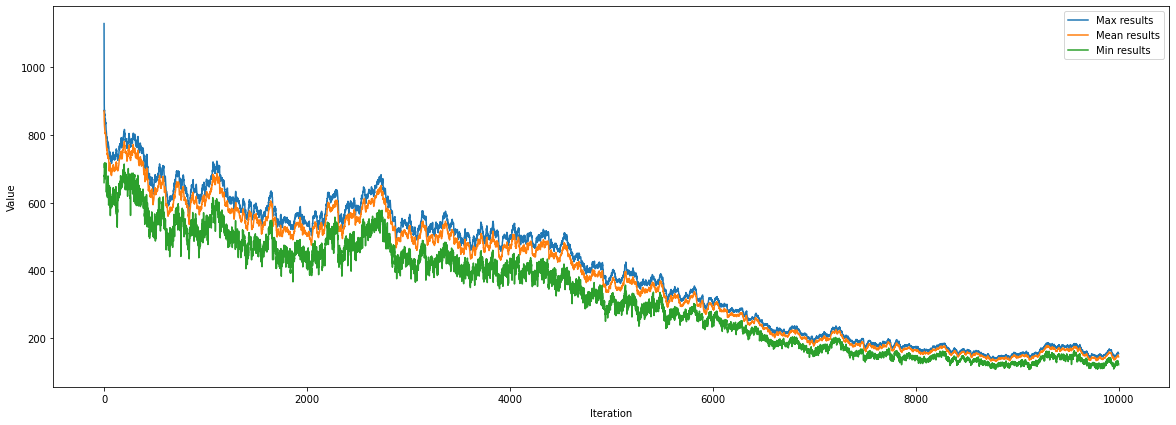

[-0.22735716 -0.22668987 -0.65455389 -0.40953131  0.05456818  0.01462833
 -2.04995102 -3.49887855 -0.16504706 -1.91803362  0.72159319  0.79360759
 -0.69000216  0.85176952 -0.21392359 -1.05605194  0.62631097  0.73621583
  0.37366201 -0.56943525 -1.20406456  0.33541369 -0.07767705  2.84552675
 -1.2149821   0.60377094  1.36830918  0.79358916 -0.39458646  0.06220449
  0.7175879  -1.2028611   0.88763046  0.49727814 -0.30320266 -0.34424386
 -0.94414715  0.34631971  0.57898157  0.95699476 -0.50737961 -0.0488959
  3.00878343 -0.46579632  0.45746932  0.8537803   1.16386502  2.35313289
 -2.20975302 -0.69108162  1.56346264  0.13439053 -0.38034048  0.94014845
 -0.59173852 -1.07462116 -1.07199224 -1.33354756 -0.54301998  0.56957644
  0.2496202  -0.17099946  0.28481591 -0.63690481  0.82898114  1.7782645
 -0.24412808  0.62137504  0.45369894  2.00201742 -2.38514648  0.17508478
 -1.64875519 -0.77824956  1.38617192  0.7339431   0.27566835  2.35679097
 -0.45829513  0.0675353   0.22780552 -0.29557696 -1.2

In [18]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(sphere, chromosomes, 100, 200, (-5.12, 5.12), is_mi_plus_lambda=False)
    plot_chart(res)
    print(res[0])

Sum squares

In [19]:
def sum_squares(individual):
    return np.sum(np.arange(1, len(individual) + 1) * individual * individual)
print(sum_squares(np.array([1.0, 2.0, 3.0])))

36.0


Mi + lambda

20


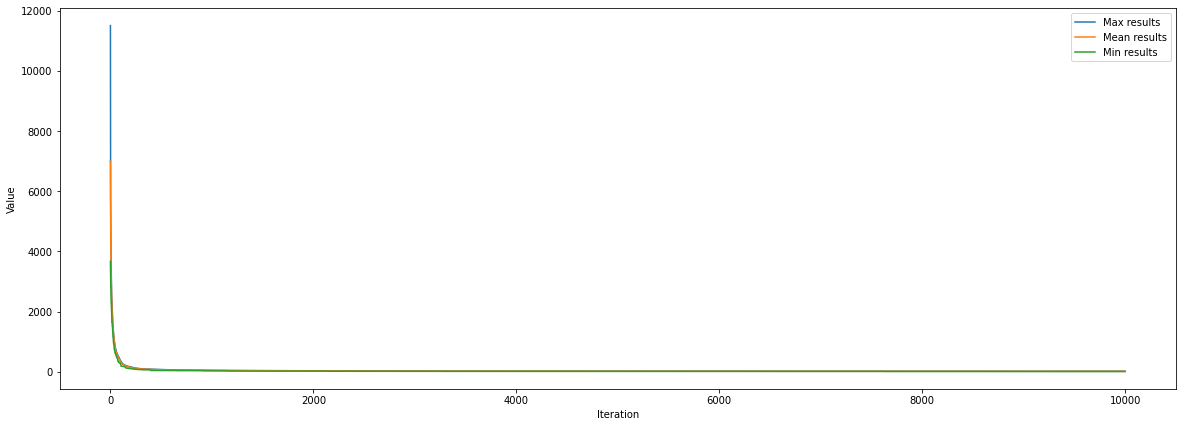

[-0.47683204 -0.31229578  0.20039166  0.20911042 -0.11213966 -0.54940792
  0.04626218  0.05075051  0.28049109  0.09138587 -0.00797629 -0.44993744
  0.03225173 -0.10657258 -0.20665512  0.17645975  0.18723876 -0.19595565
  0.04428212  0.26352479]
50


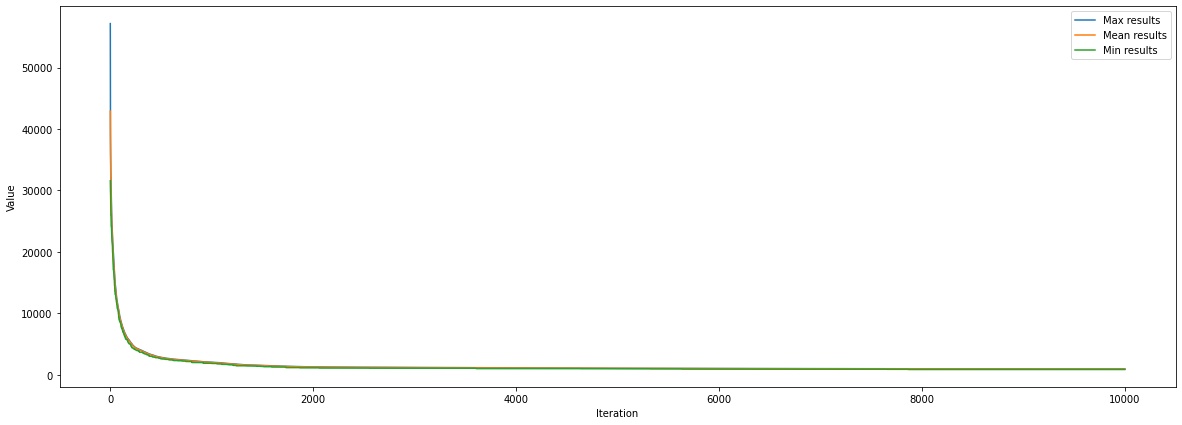

[ 0.61331397  0.35681798  0.94764933 -0.50441908 -0.19376614  0.78657157
 -0.75234777  2.25755801  0.11841058 -0.72267478 -0.04435075  0.50032837
 -0.3633088   0.10524696  0.21222091  0.19942999 -0.16543078  0.08847534
  0.14936674  0.34843386 -0.34106728  0.41184923  0.41661285 -0.06414981
  4.95580813  1.31207179 -0.32611827  0.02008867  0.11310475  0.2352058
 -0.30887234  0.33666616 -0.65518816  0.24380409  0.80895887 -0.04301884
 -0.24451238 -0.40766209 -0.36080018  0.40956599 -0.26435625  0.19199343
  0.06540499  0.84979725  0.17965414  0.31085207  0.25003842  0.02145336
  0.06839817  0.32559393]
100


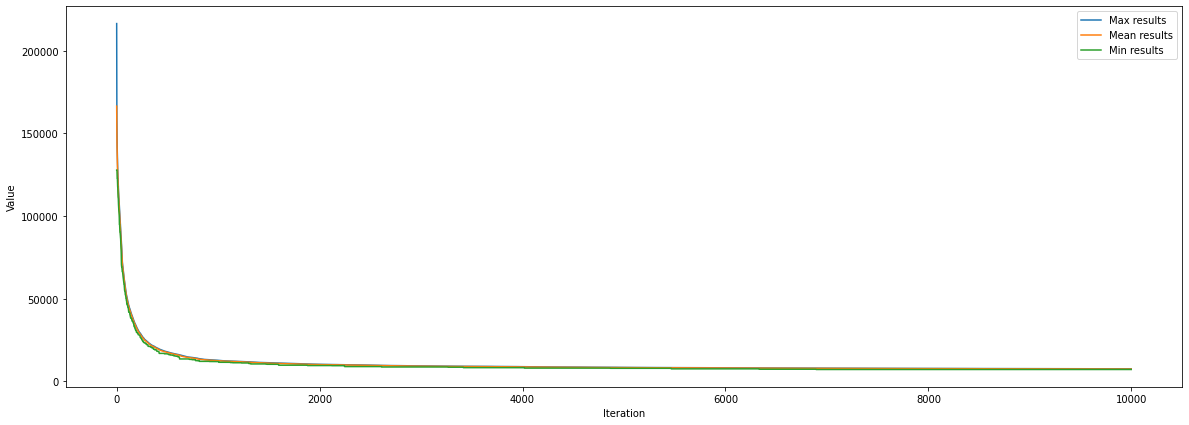

[-7.85847710e+00 -2.82509928e+00  2.98424074e+00  3.43823930e+00
  3.75636348e-02 -8.17236996e-01 -4.05760927e+00  5.19583364e-01
  4.75266360e+00  1.27597711e+00  1.31762622e+00  9.36021160e-02
  3.19494874e+00  3.36171091e-01  5.13679686e-01  8.40715397e-01
 -2.61082521e+00  1.28172100e+00  5.75170858e+00 -9.98129756e-01
 -2.92511814e+00  1.16924685e+00 -2.54210523e-01 -1.32891969e+00
  1.29809649e+00  3.85586825e-01  4.51547707e-03  1.88939941e+00
  2.81917795e-01  4.27762147e-01  1.37670118e+00 -2.84628341e-02
  1.93621177e+00 -2.25927176e+00  3.11766720e-01  2.48497652e+00
 -1.06855371e-01 -5.53933312e-01 -1.13093400e+00  8.50489666e-01
 -3.99846795e-01  5.42329259e-01 -1.23819322e+00 -9.60873725e-01
  1.10871131e+00  3.55098925e-01  3.12325290e-01 -1.63132406e-01
  1.19528859e-01  9.48051373e-01  1.27575654e+00 -3.78003132e-01
  8.09550077e-01 -1.16004126e+00 -4.50581373e-01 -9.64596344e-02
  1.39682501e+00  2.25677831e-01  6.47496777e-01 -2.64185574e-01
  3.52544928e-01 -4.87742

In [20]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(sum_squares, chromosomes, 100, 100, (-10, 10))
    plot_chart(res)
    print(res[0])

Mi, lambda

20


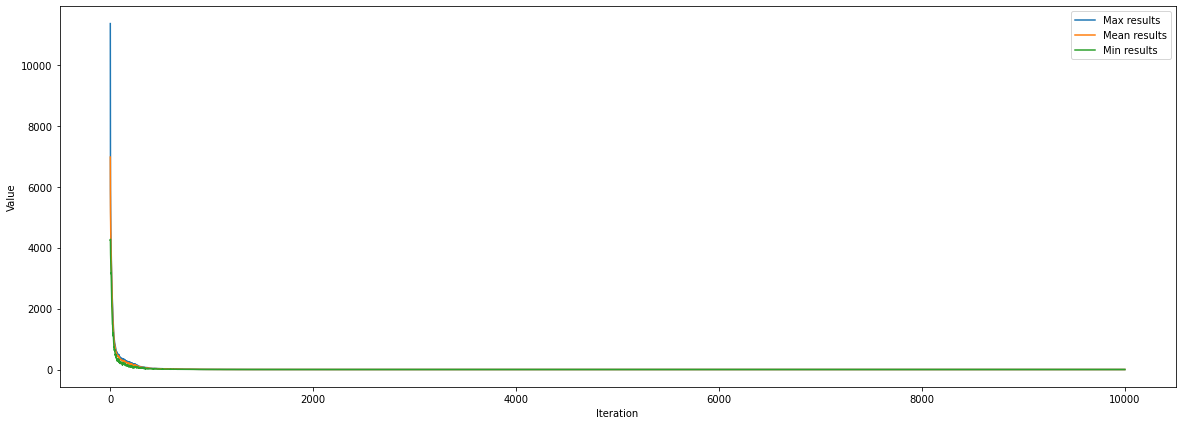

[ 2.07632434e-09  1.00014912e-10  6.31555529e-10  1.77376450e-10
  1.13737140e-09 -2.51364632e-10 -7.68869782e-10 -9.21760978e-10
 -3.23914682e-10  1.93395534e-10 -2.71583535e-10 -4.63561134e-10
  8.85620462e-10  9.73587207e-10 -2.77763396e-10  1.53461689e-10
 -1.77293755e-10  2.11135194e-10  3.27861915e-10 -7.34612379e-10]
50


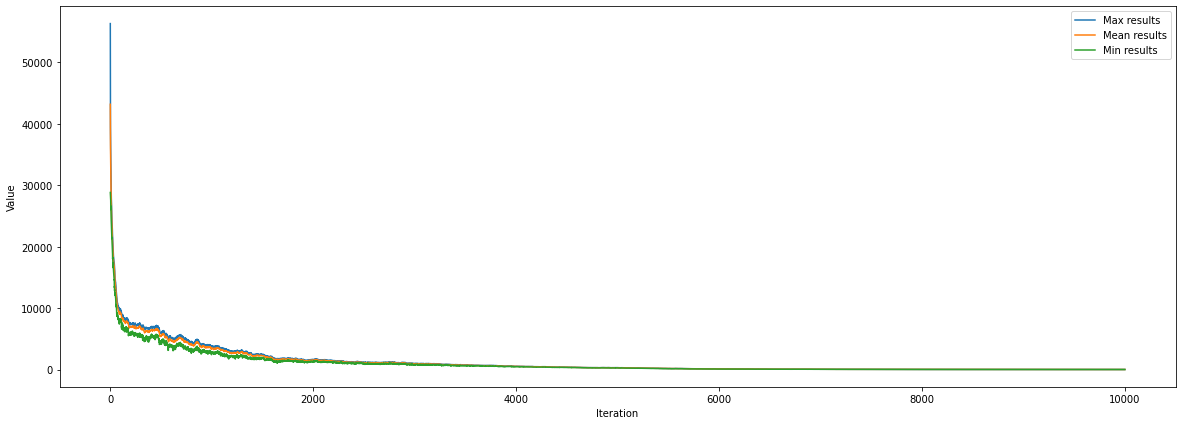

[-0.14111676  0.17607867 -0.01951118 -0.01098494 -0.03749071  0.0226897
  0.04513275 -0.01269556 -0.01432887  0.01937841 -0.03026674  0.05276465
  0.04920236 -0.02301809  0.05125975  0.00106698 -0.01478138 -0.06592884
 -0.03516662 -0.01241876  0.03743752 -0.00408565  0.00663149 -0.02902995
 -0.00018859  0.0079746  -0.00351152  0.01910231 -0.00174177 -0.01860094
  0.0151285  -0.04841018  0.080544    0.00527441 -0.01114665 -0.03542226
  0.00751104  0.02109486  0.0190839  -0.02301526 -0.00425532  0.03652485
  0.00184171  0.02020937 -0.00688256  0.00886036  0.00306903 -0.01107843
 -0.00335104  0.0197239 ]
100


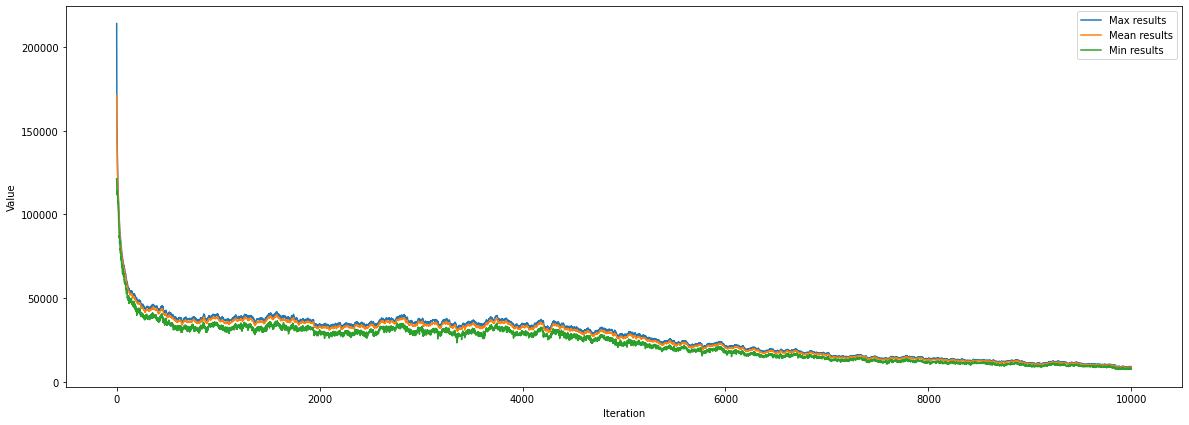

[ 4.68705382 -1.82628833  1.50027601 -0.42453027  5.88320616  1.02175431
 -0.74283303 -0.49306285 -0.89999105  0.91056062 -0.53691317  2.78518299
 -0.22268935  2.59731666 -0.04402751  0.37506563  1.60435792  1.03037272
 -0.79781733 -1.53321458  0.18858107  2.58542962  1.56227314  0.56485732
  1.98720749 -0.97150157 -1.74317701 -1.04846245 -1.83980279 -0.59386876
 -0.16260351 -0.87861384 -0.70540167  0.69553148 -1.57115294  0.80720235
 -0.43192415  1.23278269  0.05905485  0.82322495 -0.29023874 -2.56150182
  1.20216576  0.54530143 -0.97929229 -0.70331536 -0.8751872   0.72232247
 -0.20895239  3.02285206 -1.44117211 -2.73262639  0.60280141  0.03449715
  1.21099705 -0.411231   -0.82016517  0.32386043 -0.98658229 -0.53312054
  0.48560144  0.33210114 -1.39565314  0.39571342 -0.0300463  -1.03552354
  0.09696368  0.32982113  0.41934978  0.19411088 -0.16954508 -0.20811295
 -6.49655075  1.4673345  -0.48844416 -1.18197629  0.69973103 -0.49640925
  0.39087871  2.23243767  0.18837783 -0.24615188 -0

In [21]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(sum_squares, chromosomes, 100, 200, (-10, 10), is_mi_plus_lambda=False)
    plot_chart(res)
    print(res[0])

Griewank

In [22]:
def griewank(individual):
    return (np.sum(individual*individual) / 4000) - np.prod(np.cos(individual / np.sqrt(np.arange(1, len(individual) + 1)))) + 1

Mi + lambda

20


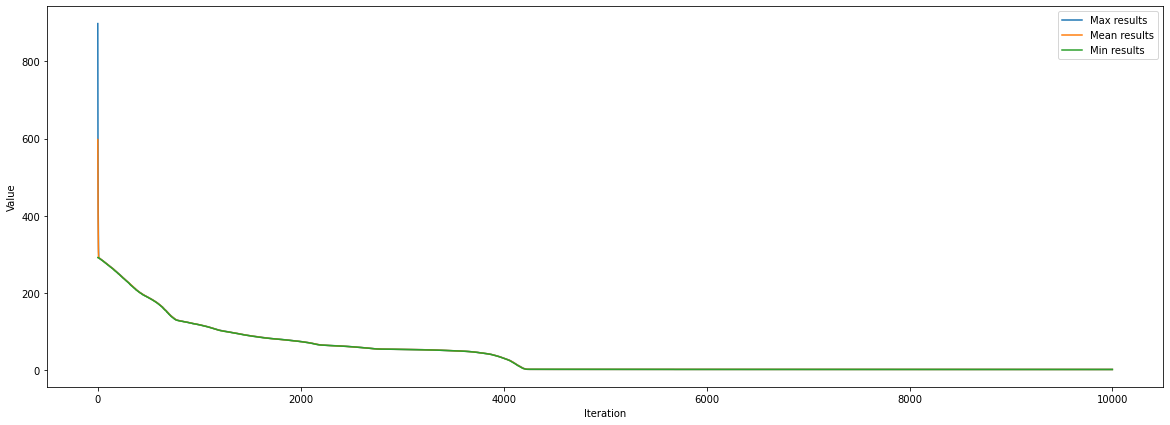

[ 0.37527354  4.83395324  1.28340675 -0.33193043  0.81990572 -0.15982526
  0.31268645 -1.23449321  1.06012571 -0.48120885 -9.05743025  0.47638528
 -0.9077779  -0.14732934  2.28144513 -0.09687651 -0.61254235  0.55617598
  1.52604366 -0.5519763 ]
50


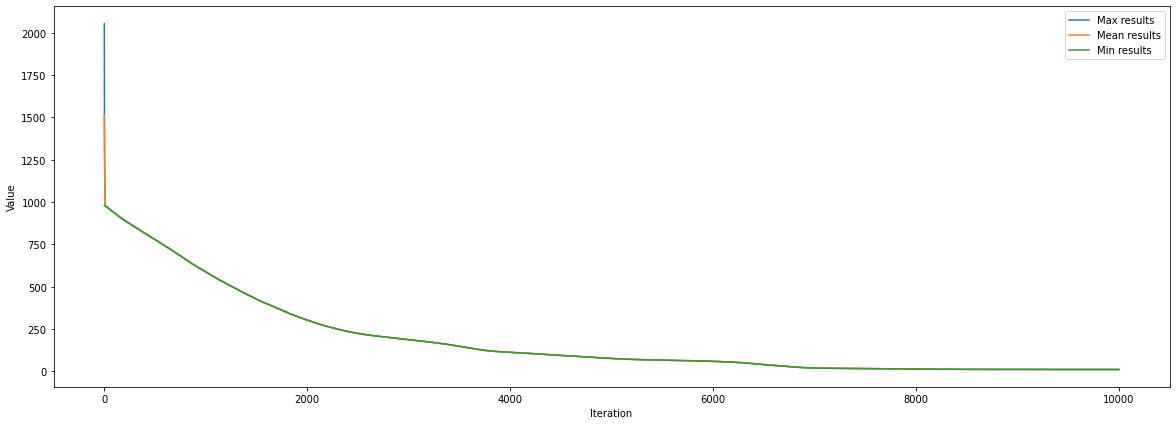

[-4.11655893e-01  3.55917169e+00  1.56064720e-01  2.60021574e+00
  4.27981755e+01  3.09052857e+00 -3.03700684e+00  1.17565913e+00
  4.84573998e-01  1.76812307e+00 -3.38275162e+00 -1.37133081e+00
  8.02185607e+01  2.29094581e-01  1.27226614e-01  8.66136196e-01
 -1.00106953e-01 -1.12233016e+00  2.06098953e-01 -1.24945201e+00
  1.89038098e+00  1.75381614e+00 -1.19853822e+00 -4.37128362e-01
 -8.48146345e+01  1.09600145e+00  2.52865923e+00 -2.18887558e+00
 -9.81069562e-01  7.59315359e-01  1.42165707e+00  2.87141638e+00
 -1.70485742e+00  2.20411984e+00  7.66189095e-01 -1.62561424e+00
  1.45924599e+02  2.64268927e+00 -4.33544855e-01 -1.01946444e+00
 -9.28618463e-01 -2.17388808e+00  9.69943099e-01 -3.95312074e-02
 -6.06511888e+00  1.34885848e-01  2.88258745e+00  2.47989013e-01
 -3.50359168e+00 -1.16025880e+00]
100


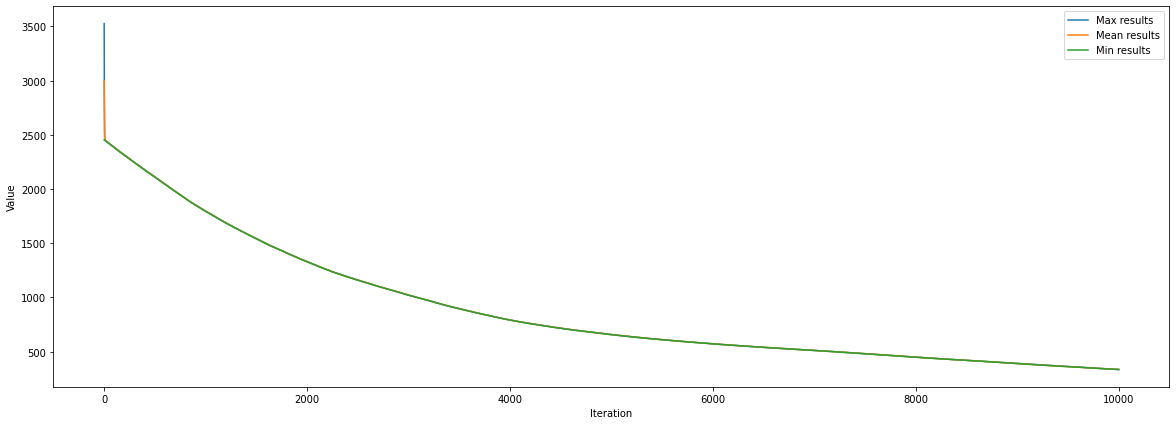

[ 6.63824270e+00  5.81816920e+00 -1.82663242e+01 -3.94500144e+01
  6.73774530e+00 -2.74724563e+00  6.07676571e+01  2.74970430e+00
  7.24927833e+00 -2.45360210e+01  1.35733076e+01  2.41912263e+00
  5.62130295e+00  2.29584819e+00 -1.70172976e+01  1.87034881e+02
 -5.45952150e+00  4.76472494e+02 -4.67339949e+02  1.17464814e+01
 -2.01188977e+02 -2.14963386e+01  8.15634851e+00  7.78919878e+00
  8.81877987e+00  7.29560950e+00 -3.06505959e+00  1.33390116e+01
  1.00925055e+01  2.26794475e+00  6.02714389e+00  3.78434179e+00
 -6.39855158e+01 -2.77010284e+00 -9.44910149e+00  3.93849306e+02
 -1.08632807e+01  2.65152902e+00  2.13352125e+02 -6.63121752e+00
 -2.07481608e+01  2.15650629e+01  5.68689883e+00 -9.87150285e+00
 -1.20383940e+01 -2.39563434e+02  1.70674475e+00  1.21918194e+01
  3.16943441e+00 -4.99019922e+00 -2.36803218e+01  6.52499976e-01
 -4.15324237e+00 -6.65820044e+00 -6.72689107e+00  5.76716666e+00
 -1.59571884e+00  4.19476868e+00  7.84554430e+00 -3.66064830e-01
 -1.16052152e+01 -2.11931

In [23]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(griewank, chromosomes, 100, 100, (-600, 600))
    plot_chart(res)
    print(res[0])

Mi, lambda

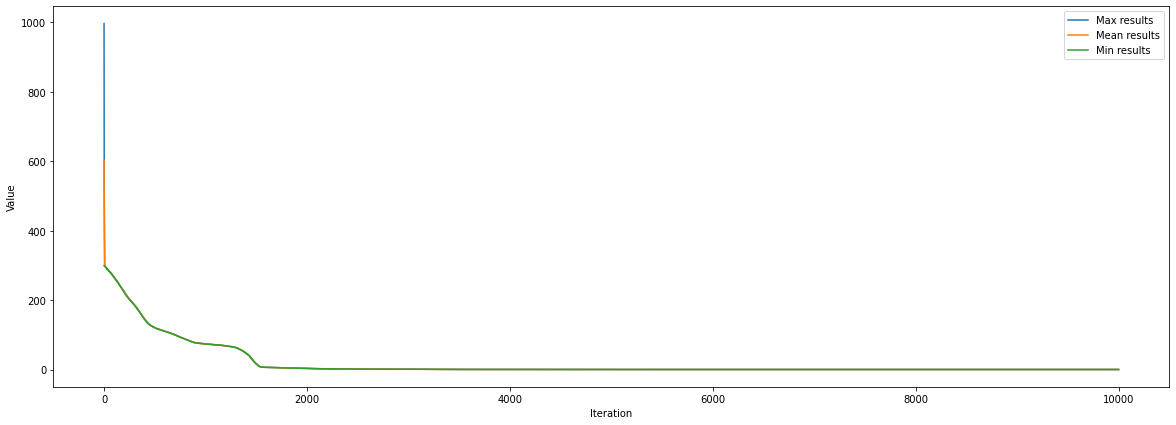

[ 8.27841206e-08  1.40613733e-07 -8.63472119e-08 -1.01393451e-08
  6.96415121e-08  8.71469698e-08  2.73037818e-08  1.53523426e-07
 -4.91313153e-08 -7.62322111e-08 -2.47539469e-07  1.08329647e-07
 -7.13037439e-08  4.03662965e-08 -3.51568354e-08  3.18479372e-07
 -2.99931887e-07 -4.57998330e-07 -7.67149077e-07 -1.04723241e-08]



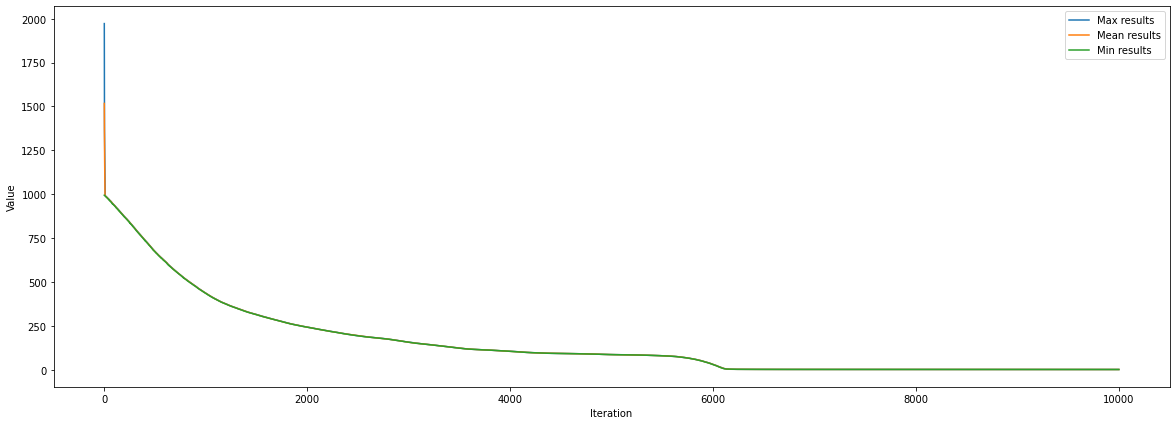

[ 7.38980200e-02 -1.43590808e-01 -1.09625866e+00  1.67740211e-01
  2.56059387e+01  8.79817219e-01  3.00328081e-01  8.13390221e-01
  4.66788096e-01 -8.80517649e-01  1.18592460e+00 -1.08338318e+00
  2.23825560e-01  7.37852714e-01  8.02412946e-02  6.05069372e-03
 -4.51714430e-01 -1.22734162e+00 -3.91002709e-01 -5.80034690e-01
  1.99824838e+00  1.24633927e+00 -3.19099176e-01  3.32312704e+00
  2.94485409e-02  5.23048401e-01  8.52543279e-01  1.44068665e+00
 -2.61937468e+00  3.17361018e+00  7.39122491e-01 -3.55706130e+00
 -5.89721882e-01 -3.78366295e-01  2.13731366e+00 -1.26910413e+00
 -3.81954044e-01 -3.53304930e-01 -1.37361468e+00 -2.48763982e-01
  7.79673771e-01  2.31948616e+00  8.86949338e-01  8.72477123e-01
  6.28806589e-01  3.51226457e+00  2.01154955e+00 -3.59758966e-01
  5.04138397e-01 -4.22182596e-01]



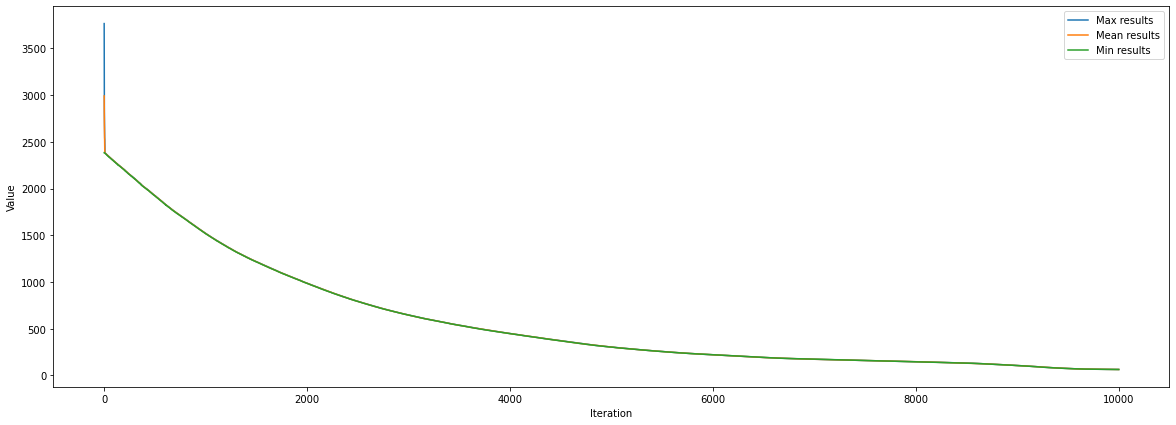

[-4.86653499e+00 -3.49333114e+00  6.06416250e+00  1.76818899e+01
 -9.23346737e-01 -2.09808230e+00  2.83596843e+00 -1.86950456e+01
 -2.68876011e+00 -3.36005903e+00 -8.49186892e+00  9.48395871e+00
  1.23708205e+00 -9.76574817e+00  6.44392661e+00  6.49088874e+00
 -2.14639275e+01 -6.97649621e+00  6.70871034e-01  7.33387264e+01
  1.27290705e+01  4.30528838e-01 -4.25153760e-02 -2.08254566e+00
  1.89371388e+01 -1.28471608e+01  6.63936430e+00  3.15648818e+01
  9.35719486e+01  1.36253173e+01  1.98274727e-01  2.55697114e+00
 -7.48128197e+00 -2.04201677e+00  1.67038780e+00 -5.23185547e+00
 -1.00001637e+01 -5.02320094e-01  4.01958459e+00  9.09236057e-01
 -1.93682683e-01  5.79938237e+00 -1.88053062e+00  1.74765049e+00
  1.65023422e+00  2.55280822e+02  8.39288054e+01 -2.33551106e+02
  1.55999568e+01 -7.19097015e+00 -1.77402363e+01  8.03313099e+00
 -4.73904344e+00 -1.20969832e+02  1.48189082e+01 -9.49045237e+00
 -2.02261307e+00 -1.88507707e+00  1.11742391e+01  3.73253784e+00
  9.75391326e-01 -8.35255

In [24]:
for chromosomes in [20, 50, 100]:
    print()
    res=ES_mi_lambda(griewank, chromosomes, 100, 200, (-600, 600), is_mi_plus_lambda=False)
    plot_chart(res)
    print(res[0])

Rastrigin

In [25]:
def rastrigin(individual):
    return 10 * len(individual) + np.sum(individual * individual - 10 * np.cos(2 * np.pi * individual))
print(rastrigin(np.array([1.0, 4.0, 5.0])))

42.0


Mi + lambda

20


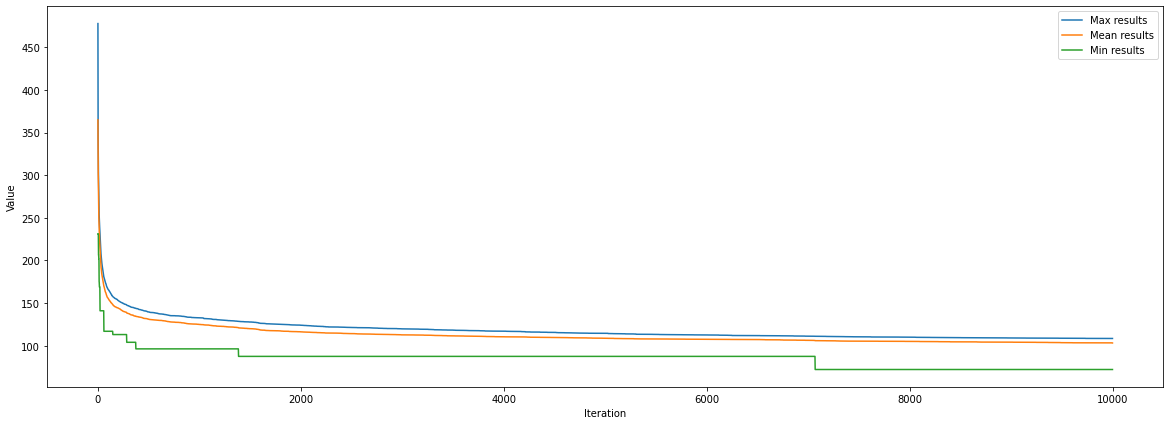

[-1.07396396  2.20844248  0.11256189 -1.0681857   1.42264502  4.09305802
 -0.94957413  0.01437242  1.01876176 -1.02386203 -0.94385307  0.01448272
 -0.9794438  -0.02570496  0.96599806  1.01668502  1.01325931 -0.14264209
  0.03950972 -0.02376789]
50


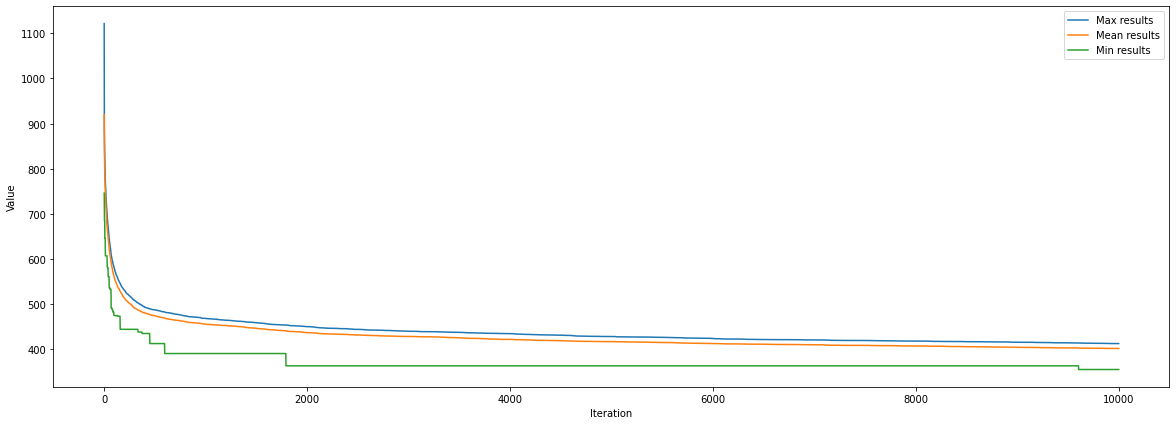

[ 0.24634165 -0.99318791  2.1378407   4.95596547 -1.08054016 -3.04824327
 -0.13609495  1.21669189 -1.04479033  0.1972451  -0.21814233 -2.25591839
 -0.95848082 -0.08487698 -0.07241061  0.82287944  0.09669469 -2.20693704
  0.90505776 -2.08891879  0.98513291  2.36485115  1.0660329  -2.08452781
  0.42775958  0.51407778  2.14150733 -0.11934934 -2.96175367  3.05113491
 -1.06657758  1.94352131 -0.03033733 -1.55621768  2.99596682 -0.04822403
  0.92416598  1.0269247   1.52963151 -0.01857142 -0.16504252  1.97148516
 -0.04193398  1.19252346  0.96975903 -0.8089633  -2.30882908  0.94603735
 -1.99532682  1.21222473]
100


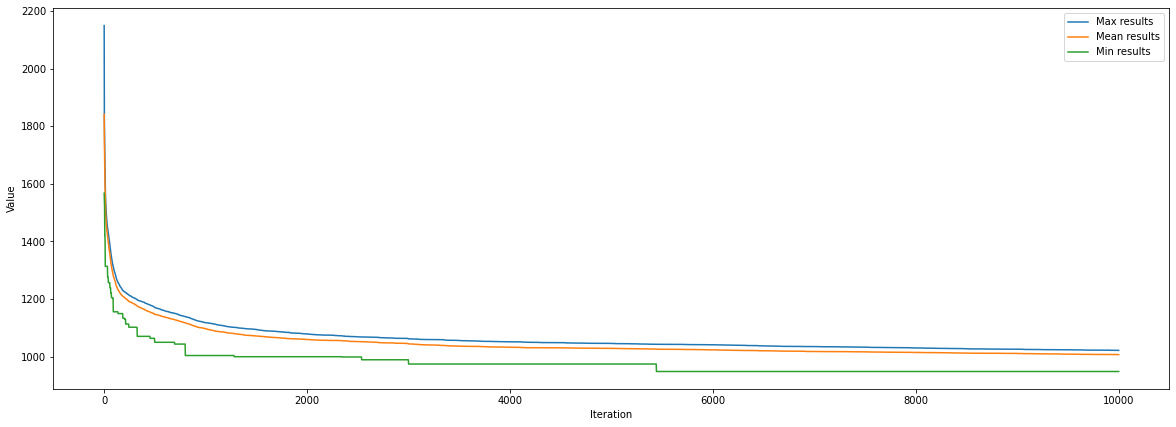

[ 1.10284095 -2.70857208  1.38143439  1.98878469 -4.16077163  0.88801126
  0.06709129 -0.83482782 -0.9223449  -1.162159   -0.14368522  1.15790272
  1.00322871 -0.70765267 -1.19537333 -0.62323846  1.96241094  0.95349997
 -0.0332535   1.9690896   1.99353249 -0.11165337  0.10374195 -0.8576279
  2.21765323  3.48278022  3.92397041  4.39431221  1.22886647 -0.74419567
 -2.35720203 -3.72279035  0.30262944 -0.62456473 -3.91746354 -1.7105808
 -0.86221801  0.88932263  1.50583538  1.30055965 -0.28694021  0.89454213
 -2.56774438  1.07480065  1.29758164 -0.05581333 -1.11153637 -2.01119973
 -0.84288157  1.69838921  1.7837701  -0.0895842  -0.07502016  0.12164458
 -0.08619877  2.92053279  2.71973085  0.83527866 -0.03155068 -0.18992525
  1.98299417  0.00673976  1.31840836  0.1201369   0.30462959  2.19979823
 -0.07401542  0.05035136 -0.07657501 -4.07523685 -1.06709228  0.99823331
 -2.1337732  -4.21705953  4.42556294 -0.94354924  1.4412245   2.04105788
  3.36676846  1.84322782  0.86992819 -3.86322158  4.0

In [26]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(rastrigin, chromosomes, 200, 200, (-5.12, 5.12))
    plot_chart(res)
    print(res[0])

Rosenbrock

In [27]:
def rosenbrock(individual):
    return np.sum(100 * (individual[:len(individual) -1] ** 2 - individual[1:]) ** 2 + (1 - individual[:len(individual) -1]) ** 2)
rosenbrock(np.array([0.0, 0.0, 0.0]))

2.0

Mi + lambda

20


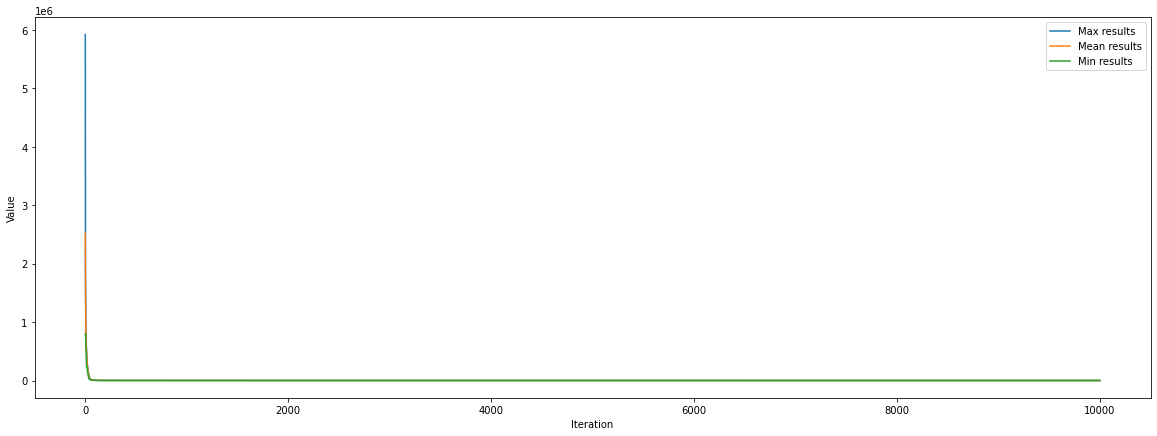

[ 0.30171543  0.0138617  -0.16290953 -0.02561915  0.25855263  0.24873208
  0.20339283 -0.03125409  0.19391782  0.09989028  0.20962421 -0.16106525
  0.14849616 -0.02475077 -0.44740567  0.54257962  0.41561842  0.35197029
  0.34886886  0.28384479]
50


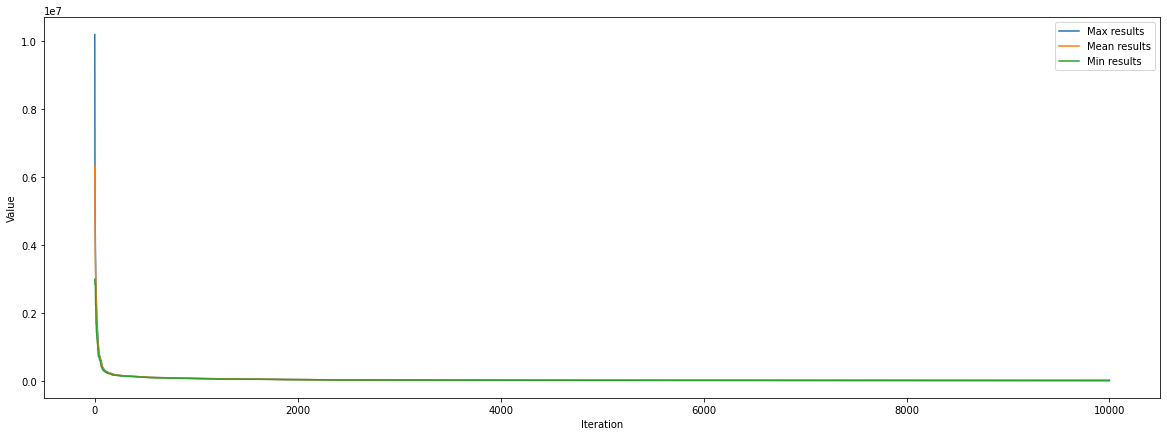

[-1.14919656e+00  1.23484325e+00  2.70668826e+00  1.09026146e+00
  8.91749469e-01  5.35673930e-01  6.86004763e-01 -1.94365499e-01
 -6.41198937e-01  3.83704938e-01  3.97310951e-01 -8.39373086e-01
  1.04722746e+00  3.31968977e-01  3.36635712e-01  7.42352646e-01
 -8.87218776e-02 -4.76925438e-02 -7.80383624e-03  4.96435502e-01
  3.25277455e-01 -1.50189458e+00  1.12140049e+00 -6.99839796e-01
  6.25718388e-03 -3.94952823e-01  2.53305257e-01 -2.24670502e-01
 -7.50427508e-01 -1.84090896e-01 -2.57212681e-01 -1.23866202e+00
  2.06272484e-01 -5.72554273e-01  9.45538385e-01  3.59028093e-01
  3.70739350e-01  2.39105368e-01  3.19563022e-01 -9.76113727e-02
  7.35639456e-01  5.01398130e-01 -2.53351778e-02 -1.09718160e-01
 -1.73898775e-01  6.50730885e-02 -1.78096181e+00  1.83195427e+00
  3.19144958e+00  9.33710770e+00]
100


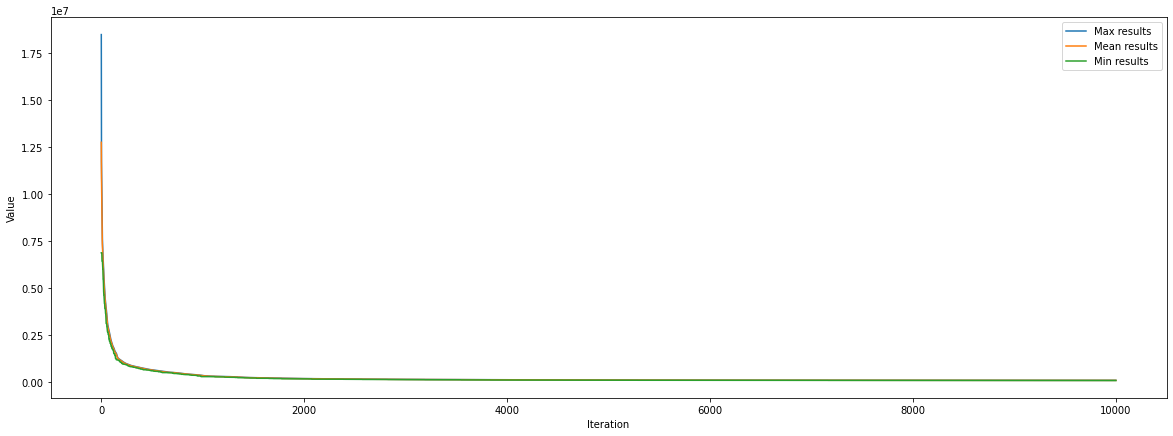

[ 1.17121293  0.53148167  1.77882887  1.2306446   1.13356166  0.23200627
 -2.86531658  0.48749534  1.5763365   3.89240541  2.06021753  1.57595832
  0.65876696 -1.2886287  -1.22498824 -0.07150029 -0.72473614 -0.40336335
 -0.46543793  1.04173513  0.4660021  -0.33153078  0.29499847  0.08002884
  1.20656952  0.15553978 -2.38990573  1.81382127  0.33103001 -0.30995415
 -1.0965063  -0.05305828 -1.29749594 -0.21653715  0.77270935  0.22234268
  0.14124144 -0.29181806 -0.44695499 -0.88254323 -1.14378228  0.91364076
  1.66681545 -0.22152828  0.546743   -0.37682828 -0.82677204  0.26065111
 -0.15352125 -0.09379465  2.47375805  1.60609093  0.71151263  1.60776539
  1.62311821 -0.94498334 -1.59217677  0.29458216  0.5785239   2.03220977
  0.44225456 -0.6389621   0.15083031  0.93236712  1.84494975 -0.25082048
  0.651623    0.09237371 -0.38361993  1.66053752  0.70018504 -0.91229104
 -0.76992426 -0.901307    0.91165234  0.77164239 -0.10264747  1.61127867
  1.54246411  1.76918713  4.01935501  2.15090588  1

In [28]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(rosenbrock, chromosomes, 100, 100, (-5, 10))
    plot_chart(res)
    print(res[0])

## Zad.2

In [66]:
def constrained_random_population(chromosome_length, mi, restrictions, x_bounds, s_bounds):
    res=np.full((mi, 2, chromosome_length), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        while(not restrictions(candidate)):
            candidate=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        res[num_of_child, 0, :]=candidate
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], chromosome_length)
    return res

In [67]:
def constrained_mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length, restrictions, x_bounds):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = np.array(P_children[i, 0, :])
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
        if(not restrictions(P_children[i, 0, :]) or np.any(P_children[i, 0, :] > x_bounds[1]) \
            or np.any(P_children[i, 0, :] < x_bounds[0])):
            P_children[i, 0, :] = tmp
    return P_children

In [68]:
def constrained_ES_mi_lambda(objective_function, chromosome_length, mi_param, lambda_param, restrictions, x_bounds, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=False):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population(chromosome_length, mi_param, restrictions, x_bounds, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length, restrictions, x_bounds)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda, looking_for_max)
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

G3

In [32]:
def G3_objective_function(individual):
    n=len(individual)
    return np.sqrt(n) ** n * np.prod(individual)

In [33]:
def constrained_random_population_for_g3(chromosome_len, mi, s_bounds):
    res=np.full((mi, 2, chromosome_len), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(0, 1, chromosome_len)
        res[num_of_child, 0, :]=candidate / np.sqrt(np.sum(candidate ** 2))
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], )
    return res

In [34]:
def constrained_mutation_for_g3(P_children, chromosome_length, tau_param, tau_zero_param, lambda_param):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
        P_children[i, 0, :] = P_children[i, 0, :] / np.sqrt(np.sum(P_children[i, 0, :] ** 2))
    return P_children

In [35]:
def constrained_ES_mi_lambda_for_g3(chromosome_length, mi_param, lambda_param, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=True):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g3(chromosome_length, mi_param, s_bounds)
    evaluation_result=eval_population(G3_objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g3(P_children, chromosome_length, tau_param, tau_zero_param, lambda_param)
        children_evaluation_result=eval_population(G3_objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda, looking_for_max)
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Mi + lambda

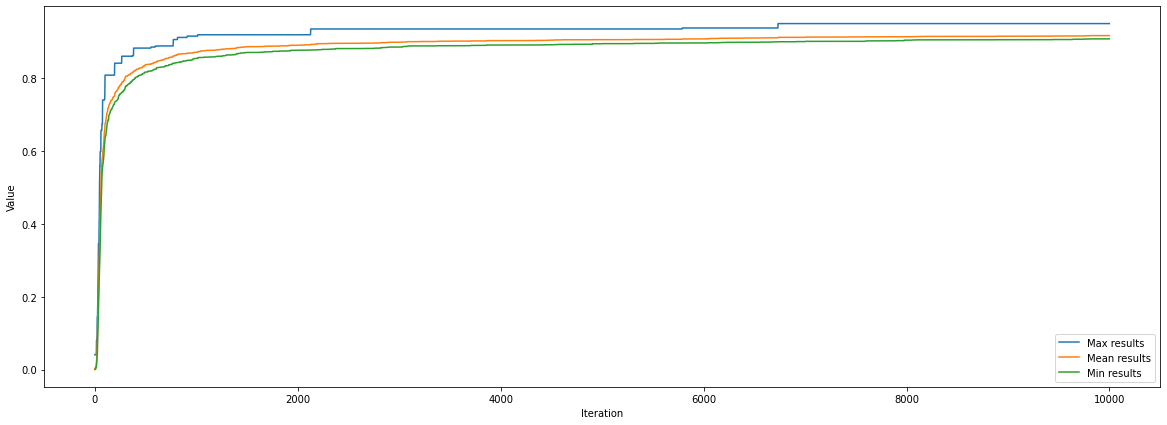

[0.22545911 0.21368931 0.23851456 0.22144526 0.22815747 0.233965
 0.23842788 0.23277981 0.22839353 0.2075402  0.20492234 0.20932596
 0.21061595 0.21176847 0.21436595 0.24080129 0.22744063 0.21565549
 0.22764234 0.23558545]


In [38]:
res=constrained_ES_mi_lambda_for_g3(20, 50, 50)
plot_chart(res)
print(res[0])

Mi, lambda

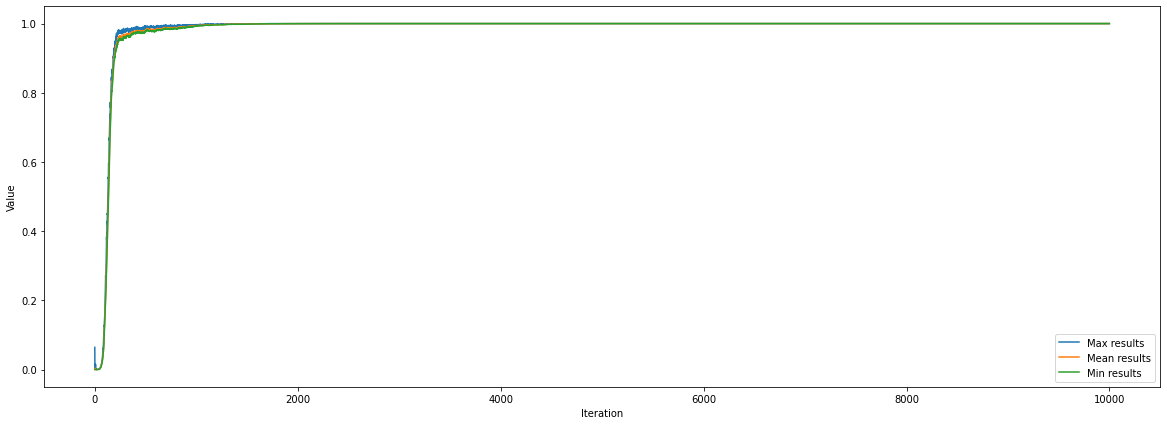

[0.2236068  0.2236068  0.2236068  0.2236068  0.22360679 0.2236068
 0.2236068  0.2236068  0.2236068  0.2236068  0.2236068  0.2236068
 0.2236068  0.2236068  0.2236068  0.22360679 0.2236068  0.22360679
 0.2236068  0.22360679]


In [39]:
res=constrained_ES_mi_lambda_for_g3(20, 50, 100, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G6

In [40]:
def G6_restrictions(individual):
    return (individual[0] - 5) ** 2 +  (individual[1] - 5) ** 2 >= 100 and (individual[0] - 6) ** 2 +  (individual[1] - 5) ** 2 <= 82.81  

In [41]:
def G6_objective_function(individual):
    return (individual[0] - 10) ** 3 + (individual[1] - 20) ** 3

In [42]:
def constrained_random_population_for_g6(mi, s_bounds):
    res=np.full((mi, 2, 2), 0.0)
    for num_of_child in range(mi):
        candidate=np.concatenate((np.random.uniform(13, 15.1, 1), np.random.uniform(0, 14.1, 1)))
        while(not G6_restrictions(candidate)):
            candidate=np.concatenate((np.random.uniform(13, 15.1, 1), np.random.uniform(0, 14.1, 1)))
        res[num_of_child, 0, :]=candidate
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], 2)
    return res
constrained_random_population_for_g6(10, (0, 1))

array([[[1.50211004e+01, 4.12463008e+00],
        [6.16049135e-01, 8.43885334e-01]],

       [[1.50338133e+01, 4.30345108e+00],
        [5.63970972e-01, 7.37712846e-01]],

       [[1.48011687e+01, 2.91154480e+00],
        [1.19524972e-02, 3.55331489e-01]],

       [[1.46187021e+01, 7.77343618e+00],
        [8.80492846e-01, 4.63237127e-01]],

       [[1.49432865e+01, 6.36630783e+00],
        [2.61708105e-01, 6.73129285e-01]],

       [[1.49594456e+01, 6.09488546e+00],
        [7.80659099e-01, 7.21582871e-01]],

       [[1.50414133e+01, 5.56600526e+00],
        [4.03575639e-01, 4.50536881e-02]],

       [[1.49339741e+01, 6.16927757e+00],
        [4.75994994e-01, 9.08433899e-01]],

       [[1.49603318e+01, 3.78263848e+00],
        [7.43594358e-01, 7.17273412e-01]],

       [[1.44261793e+01, 8.42051714e+00],
        [8.06723237e-01, 2.39022912e-01]]])

In [43]:
def constrained_mutation_for_g6(P_children, tau_param, tau_zero_param, lambda_param):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, 2) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = np.array(P_children[i, 0, :])
        epsilons_for_first_chromosome = np.random.normal(0, 1, 2) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
        if not G6_restrictions(P_children[i, 0, :]) or np.any(P_children[i, 0, :] > 100) \
            or P_children[i, 0, 0] < 13 or P_children[i, 0, 1] < 0:
            P_children[i, 0, :] = tmp
    return P_children

In [46]:
def constrained_ES_mi_lambda_for_g6(mi_param, lambda_param, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*2)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(2))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g6(mi_param, s_bounds)
    evaluation_result=eval_population(G6_objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g6(P_children, tau_param, tau_zero_param, lambda_param)
        children_evaluation_result=eval_population(G6_objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=is_mi_plus_lambda)
    best_index = evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Mi + lambda

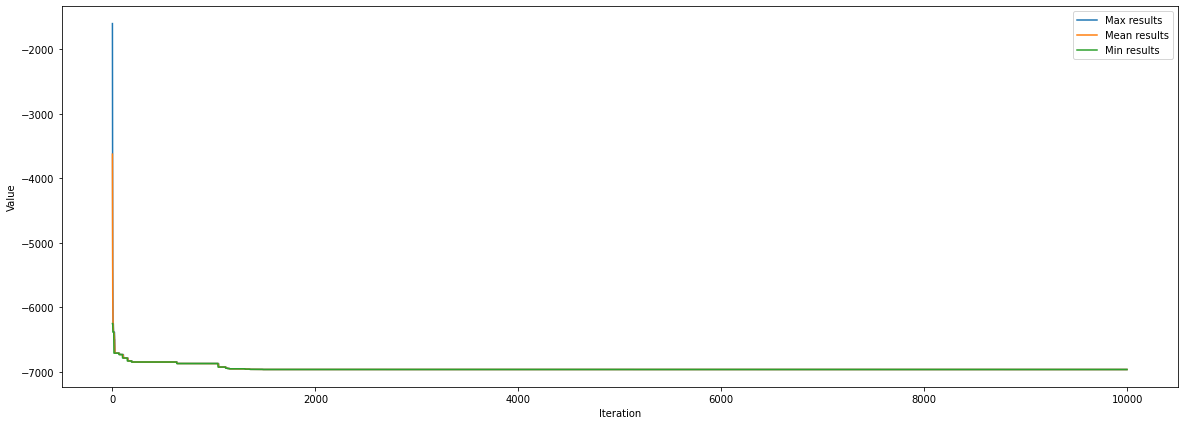

[14.09500795  0.84297665]


In [47]:
res=constrained_ES_mi_lambda_for_g6(50, 50)
plot_chart(res)
print(res[0])

Mi, lambda

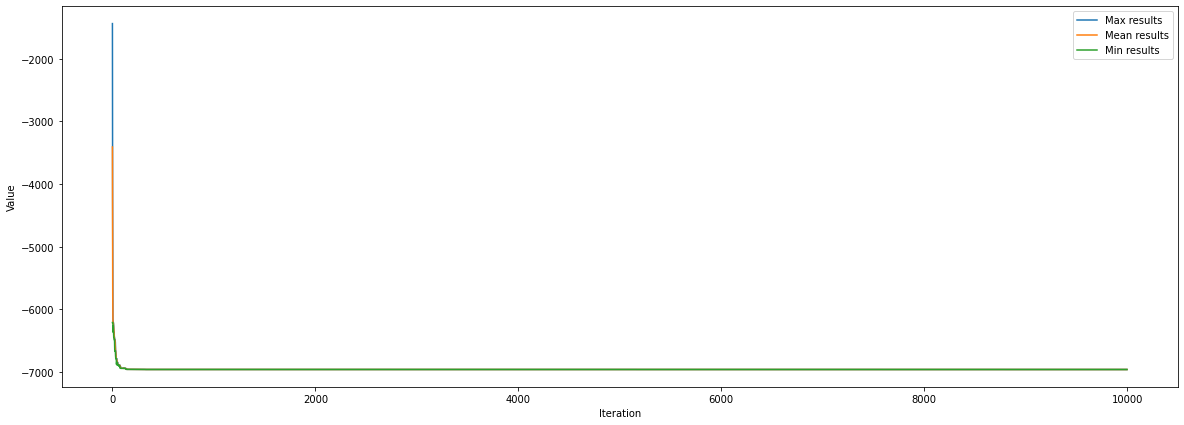

[14.095       0.84296079]


In [48]:
res=constrained_ES_mi_lambda_for_g6(50, 100, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G8

In [69]:
def G8_restrictions(individual):
    return individual[0] ** 2 + 1 <= individual[1] and 1 + (individual[1] - 4) ** 2 <= individual[0]
constrained_random_population(2, 10, G8_restrictions, (0, 10), (0, 1))

array([[[1.80790053, 4.55121936],
        [0.62978448, 0.43339709]],

       [[1.31897352, 4.5173889 ],
        [0.84962483, 0.18812007]],

       [[1.05263388, 4.18443353],
        [0.09392519, 0.30613323]],

       [[1.19157056, 4.34743652],
        [0.36528084, 0.93515304]],

       [[1.46475645, 3.65611087],
        [0.204989  , 0.13872502]],

       [[1.46752793, 3.99713995],
        [0.89153653, 0.59484904]],

       [[1.69985148, 4.45310791],
        [0.26624537, 0.76309269]],

       [[1.58517692, 4.25759297],
        [0.48937102, 0.52322531]],

       [[1.63801732, 4.55900905],
        [0.6878744 , 0.24928746]],

       [[1.66023572, 4.50349663],
        [0.66411082, 0.45164011]]])

In [70]:
def G8_objective_function(individual):
    return ((np.sin(2 * np.pi * individual[0]) ** 3) * np.sin(2 * np.pi * individual[1])) / (individual[0] ** 4 + (individual[0] ** 3) * individual[1])
G8_objective_function([1.2279713, 4.2453733])

0.09582504141801164

Mi + lambda

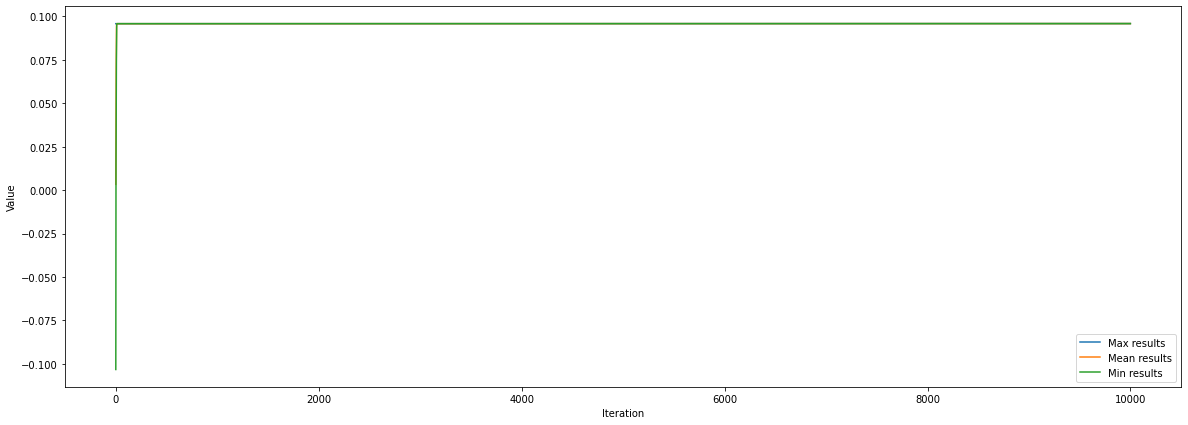

[1.22859597 4.23971633]


In [71]:
res=constrained_ES_mi_lambda(G8_objective_function, 2, 100, 100, G8_restrictions, (0, 10), looking_for_max=True)
plot_chart(res)
print(res[0])

Mi, lambda

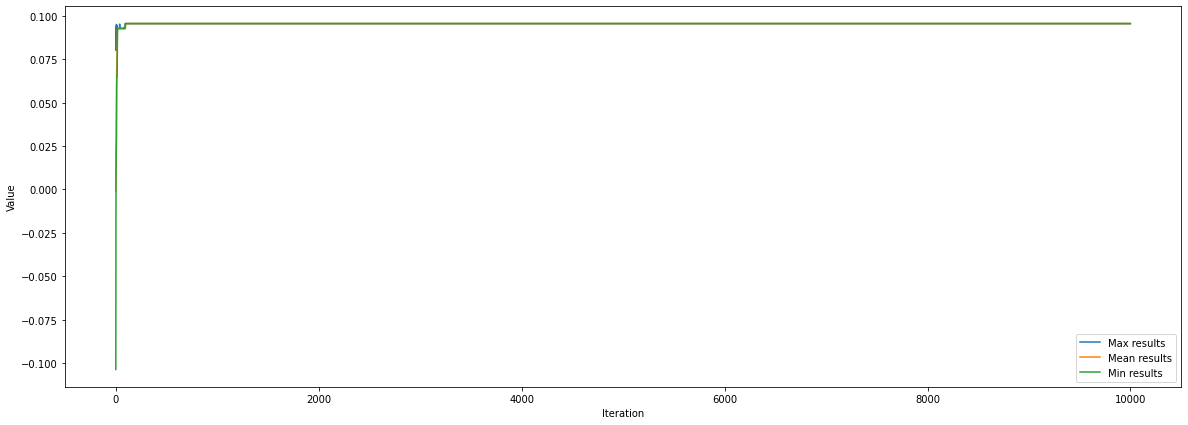

[1.23507937 4.24858916]


In [72]:
res=constrained_ES_mi_lambda(G8_objective_function, 2, 100, 200, G8_restrictions, (0, 10), looking_for_max=True, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G11

In [53]:
def G11_objective_function(individual):
    return (individual[0] ** 2) + (individual[1] - 1) ** 2

In [54]:
def constrained_random_population_for_g11(mi, s_bounds):
    res=np.full((mi, 2, 2), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(-1, 1, 1)[0]
        res[num_of_child, 0, :]=np.array([candidate, candidate ** 2])
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], 2)
    return res

In [55]:
def constrained_mutation_for_g11(P_children, tau_param, tau_zero_param, lambda_param):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, 2) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = P_children[i, 0, :]
        epsilons_for_first_chromosome = (np.random.normal(0, 1, 1) * P_children[i, 1, 0])
        P_children[i, 0, 0] = P_children[i, 0, 0] + epsilons_for_first_chromosome
        P_children[i, 0, 1] =  P_children[i, 0, 0] ** 2
    return P_children

In [56]:
def constrained_ES_mi_lambda_for_g11(mi_param, lambda_param, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*2)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(2))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g11(mi_param, s_bounds)
    evaluation_result=eval_population(G11_objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g11(P_children, tau_param, tau_zero_param, lambda_param)
        children_evaluation_result=eval_population(G11_objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=is_mi_plus_lambda)
    best_index = evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Mi + lambda

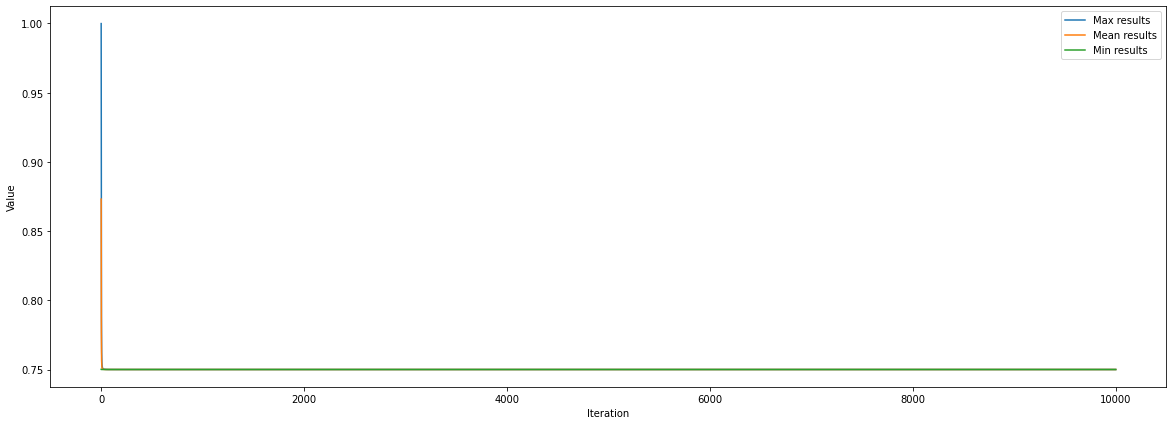

[0.70710656 0.49999969]


In [57]:
res=constrained_ES_mi_lambda_for_g11(100, 100)
plot_chart(res)
print(res[0])

Mi, lambda

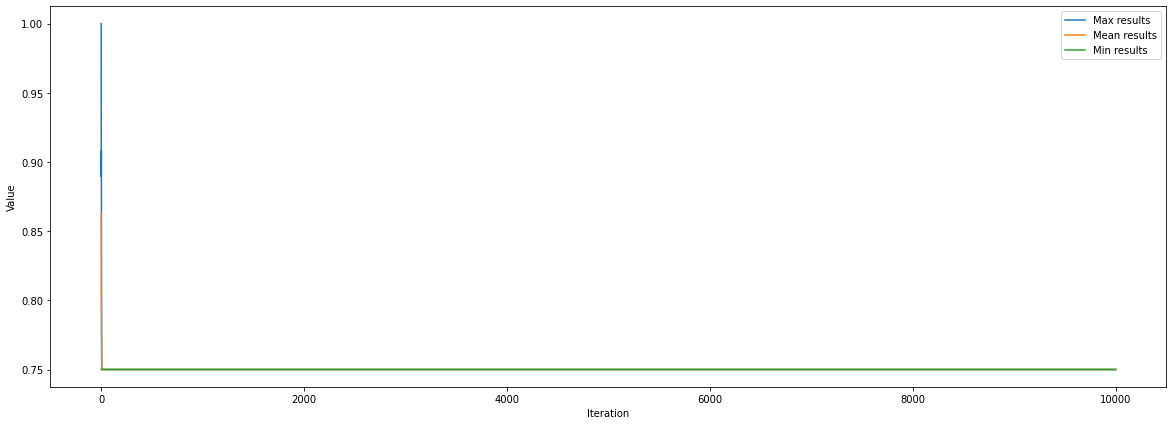

[-0.70710678  0.5       ]


In [58]:
res=constrained_ES_mi_lambda_for_g11(100, 200, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G12

In [73]:
def G12_restrictions(individual):
    for i in ([np.floor(individual[0]), np.ceil(individual[0])]):
        for j in ([np.floor(individual[1]), np.ceil(individual[1])]):
            for k in ([np.floor(individual[2]), np.ceil(individual[2])]):
                if i > 0 and i < 10 and j > 0 and j < 10 and k > 0 and k < 10 and (individual[0] - i) ** 2 + (individual[1] - j) ** 2 + (individual[2] - k) ** 2 <= 0.0625:
                    return True
    return False
constrained_random_population(3, 10, G12_restrictions, (0, 10), (0, 1))

array([[[1.91577283, 8.20611908, 1.99235175],
        [0.12613018, 0.50326112, 0.64437341]],

       [[7.11224663, 9.18671099, 1.11744198],
        [0.78168198, 0.17669241, 0.59046928]],

       [[0.90639749, 9.07264752, 4.09180295],
        [0.71182481, 0.69585   , 0.36259063]],

       [[3.13044602, 5.86705297, 4.89505524],
        [0.80093612, 0.9029488 , 0.3837645 ]],

       [[5.00174867, 3.06586315, 5.88118822],
        [0.04024869, 0.60329552, 0.76784498]],

       [[4.13515267, 9.08456922, 6.13311099],
        [0.63970025, 0.26162218, 0.20755264]],

       [[8.11010222, 8.07782177, 2.04488056],
        [0.85005376, 0.63820773, 0.63266203]],

       [[1.99193383, 8.86204022, 3.80816954],
        [0.29181806, 0.77643911, 0.02782142]],

       [[7.88932054, 5.86691527, 7.82317481],
        [0.47225659, 0.40658477, 0.85741875]],

       [[7.96889523, 1.95743467, 6.02251752],
        [0.05833562, 0.47059708, 0.99093159]]])

In [74]:
def G12_objective_function(individual):
    return 0.01 * ((individual[0] - 5) ** 2 + (individual[1] - 5) ** 2 + (individual[2] - 5) ** 2) - 1
G12_objective_function(np.array([10.0, 10.0, 10.0]))

-0.25

Mi + lambda

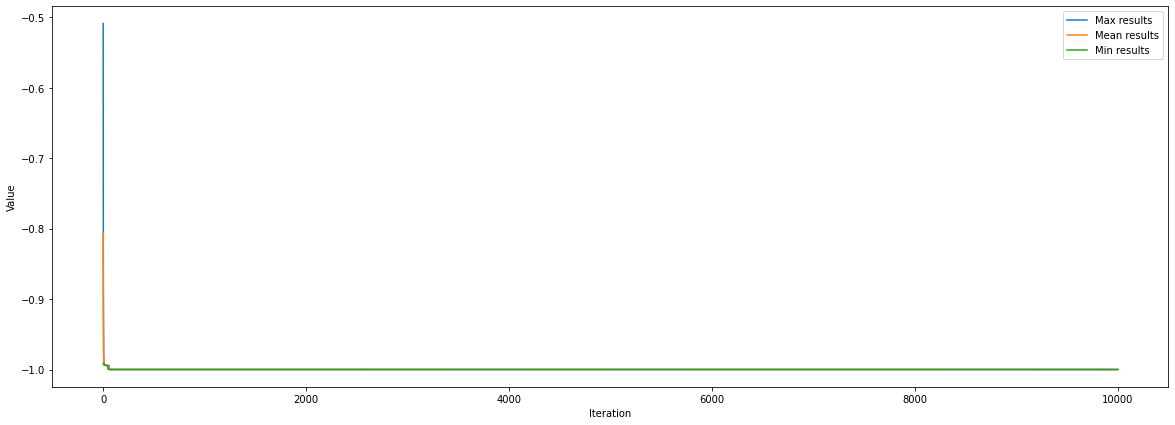

[5.00325459 5.00147603 4.99560087]


In [75]:
res=constrained_ES_mi_lambda(G12_objective_function, 3, 100, 100, G12_restrictions, (0, 10))
plot_chart(res)
print(res[0])

Mi, lambda

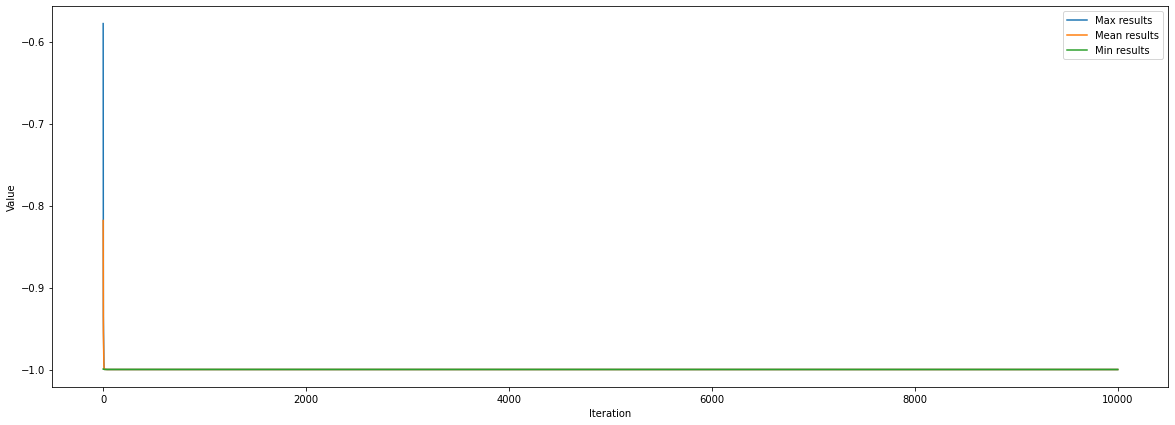

[4.99710102 4.98475968 4.99730998]


In [76]:
res=constrained_ES_mi_lambda(G12_objective_function, 3, 100, 200, G12_restrictions, (0, 10), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])